# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

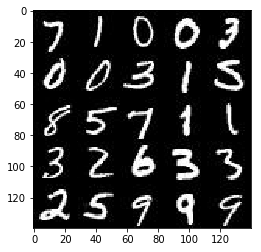

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

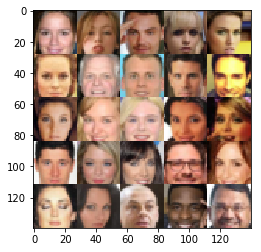

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [25]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.5):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=1, padding='same', kernel_initializer=kernel_init)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        x3 = tf.layers.dropout(x3, rate=(keep_prob), training=True)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 7x7x256

        # Flatten
        flat = tf.reshape(x3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        x1 = tf.layers.dense(z, 7*7*256)

        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.dropout(x3, rate=(keep_prob), training=is_train)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xOUT
        out = tf.tanh(logits)
    
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, output_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, output_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    print_every=10
    show_every=100
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2],data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # resize to -1.0 to 1.0
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                #Run g_opt twice
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Step {}, (Epoch {}/{})...".format(steps, epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
             

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 10, (Epoch 1/2)... Discriminator Loss: 2.7566... Generator Loss: 0.1468
Step 20, (Epoch 1/2)... Discriminator Loss: 2.3006... Generator Loss: 0.7935
Step 30, (Epoch 1/2)... Discriminator Loss: 2.2053... Generator Loss: 0.1870
Step 40, (Epoch 1/2)... Discriminator Loss: 1.4493... Generator Loss: 0.5824
Step 50, (Epoch 1/2)... Discriminator Loss: 1.1508... Generator Loss: 0.6605
Step 60, (Epoch 1/2)... Discriminator Loss: 1.7272... Generator Loss: 0.3522
Step 70, (Epoch 1/2)... Discriminator Loss: 1.6407... Generator Loss: 0.3212
Step 80, (Epoch 1/2)... Discriminator Loss: 1.2510... Generator Loss: 0.9439
Step 90, (Epoch 1/2)... Discriminator Loss: 1.0934... Generator Loss: 1.0027
Step 100, (Epoch 1/2)... Discriminator Loss: 1.5773... Generator Loss: 0.3171


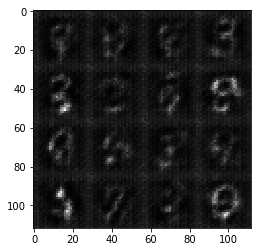

Step 110, (Epoch 1/2)... Discriminator Loss: 1.7799... Generator Loss: 0.2545
Step 120, (Epoch 1/2)... Discriminator Loss: 1.3360... Generator Loss: 1.4637
Step 130, (Epoch 1/2)... Discriminator Loss: 1.1837... Generator Loss: 1.1763
Step 140, (Epoch 1/2)... Discriminator Loss: 1.0331... Generator Loss: 0.8285
Step 150, (Epoch 1/2)... Discriminator Loss: 1.0797... Generator Loss: 1.0420
Step 160, (Epoch 1/2)... Discriminator Loss: 1.0210... Generator Loss: 1.0786
Step 170, (Epoch 1/2)... Discriminator Loss: 1.0373... Generator Loss: 1.0574
Step 180, (Epoch 1/2)... Discriminator Loss: 1.7354... Generator Loss: 0.2361
Step 190, (Epoch 1/2)... Discriminator Loss: 0.9601... Generator Loss: 0.9532
Step 200, (Epoch 1/2)... Discriminator Loss: 1.3139... Generator Loss: 0.4099


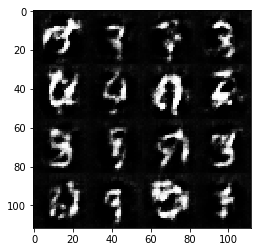

Step 210, (Epoch 1/2)... Discriminator Loss: 1.0095... Generator Loss: 0.7399
Step 220, (Epoch 1/2)... Discriminator Loss: 0.9840... Generator Loss: 0.8225
Step 230, (Epoch 1/2)... Discriminator Loss: 1.1260... Generator Loss: 0.5814
Step 240, (Epoch 1/2)... Discriminator Loss: 1.2147... Generator Loss: 1.5995
Step 250, (Epoch 1/2)... Discriminator Loss: 2.0658... Generator Loss: 0.1583
Step 260, (Epoch 1/2)... Discriminator Loss: 1.2473... Generator Loss: 0.5202
Step 270, (Epoch 1/2)... Discriminator Loss: 1.4629... Generator Loss: 0.3507
Step 280, (Epoch 1/2)... Discriminator Loss: 1.0050... Generator Loss: 1.0416
Step 290, (Epoch 1/2)... Discriminator Loss: 1.1904... Generator Loss: 0.7512
Step 300, (Epoch 1/2)... Discriminator Loss: 1.4014... Generator Loss: 0.3648


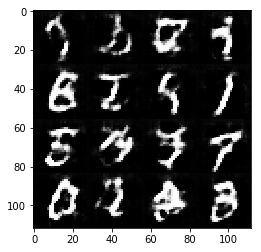

Step 310, (Epoch 1/2)... Discriminator Loss: 1.0125... Generator Loss: 0.7045
Step 320, (Epoch 1/2)... Discriminator Loss: 1.4052... Generator Loss: 0.3959
Step 330, (Epoch 1/2)... Discriminator Loss: 1.2415... Generator Loss: 0.5268
Step 340, (Epoch 1/2)... Discriminator Loss: 1.1072... Generator Loss: 0.6989
Step 350, (Epoch 1/2)... Discriminator Loss: 1.8227... Generator Loss: 0.2077
Step 360, (Epoch 1/2)... Discriminator Loss: 1.2607... Generator Loss: 0.5631
Step 370, (Epoch 1/2)... Discriminator Loss: 1.1895... Generator Loss: 0.6162
Step 380, (Epoch 1/2)... Discriminator Loss: 1.2365... Generator Loss: 0.5387
Step 390, (Epoch 1/2)... Discriminator Loss: 1.2400... Generator Loss: 0.6241
Step 400, (Epoch 1/2)... Discriminator Loss: 1.4851... Generator Loss: 0.3493


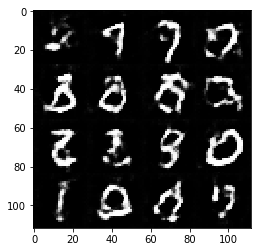

Step 410, (Epoch 1/2)... Discriminator Loss: 1.2774... Generator Loss: 0.7708
Step 420, (Epoch 1/2)... Discriminator Loss: 1.5350... Generator Loss: 0.3745
Step 430, (Epoch 1/2)... Discriminator Loss: 1.3676... Generator Loss: 0.4741
Step 440, (Epoch 1/2)... Discriminator Loss: 1.2467... Generator Loss: 1.3076
Step 450, (Epoch 1/2)... Discriminator Loss: 1.2850... Generator Loss: 0.4953
Step 460, (Epoch 1/2)... Discriminator Loss: 1.2098... Generator Loss: 0.5681
Step 470, (Epoch 1/2)... Discriminator Loss: 1.0869... Generator Loss: 0.8839
Step 480, (Epoch 1/2)... Discriminator Loss: 1.1413... Generator Loss: 1.2489
Step 490, (Epoch 1/2)... Discriminator Loss: 1.2089... Generator Loss: 0.7786
Step 500, (Epoch 1/2)... Discriminator Loss: 1.2086... Generator Loss: 0.5170


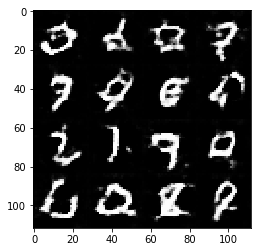

Step 510, (Epoch 1/2)... Discriminator Loss: 1.1772... Generator Loss: 0.5681
Step 520, (Epoch 1/2)... Discriminator Loss: 1.1099... Generator Loss: 0.6930
Step 530, (Epoch 1/2)... Discriminator Loss: 3.3061... Generator Loss: 2.3820
Step 540, (Epoch 1/2)... Discriminator Loss: 1.1535... Generator Loss: 0.6988
Step 550, (Epoch 1/2)... Discriminator Loss: 1.3144... Generator Loss: 0.4604
Step 560, (Epoch 1/2)... Discriminator Loss: 1.2011... Generator Loss: 0.5582
Step 570, (Epoch 1/2)... Discriminator Loss: 1.2691... Generator Loss: 1.4789
Step 580, (Epoch 1/2)... Discriminator Loss: 1.2855... Generator Loss: 0.4494
Step 590, (Epoch 1/2)... Discriminator Loss: 1.1051... Generator Loss: 0.8759
Step 600, (Epoch 1/2)... Discriminator Loss: 1.6811... Generator Loss: 0.2874


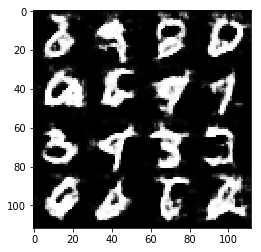

Step 610, (Epoch 1/2)... Discriminator Loss: 0.9821... Generator Loss: 0.8205
Step 620, (Epoch 1/2)... Discriminator Loss: 1.1188... Generator Loss: 0.7546
Step 630, (Epoch 1/2)... Discriminator Loss: 1.0017... Generator Loss: 0.8809
Step 640, (Epoch 1/2)... Discriminator Loss: 3.2567... Generator Loss: 2.0482
Step 650, (Epoch 1/2)... Discriminator Loss: 1.3456... Generator Loss: 0.9111
Step 660, (Epoch 1/2)... Discriminator Loss: 1.5815... Generator Loss: 0.3644
Step 670, (Epoch 1/2)... Discriminator Loss: 1.2592... Generator Loss: 0.5040
Step 680, (Epoch 1/2)... Discriminator Loss: 1.0047... Generator Loss: 0.7462
Step 690, (Epoch 1/2)... Discriminator Loss: 1.0648... Generator Loss: 0.7315
Step 700, (Epoch 1/2)... Discriminator Loss: 1.0014... Generator Loss: 0.7200


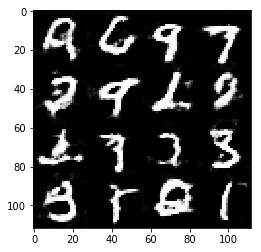

Step 710, (Epoch 1/2)... Discriminator Loss: 1.6568... Generator Loss: 0.2794
Step 720, (Epoch 1/2)... Discriminator Loss: 1.0697... Generator Loss: 1.0754
Step 730, (Epoch 1/2)... Discriminator Loss: 1.2908... Generator Loss: 0.5071
Step 740, (Epoch 1/2)... Discriminator Loss: 0.9759... Generator Loss: 0.7339
Step 750, (Epoch 1/2)... Discriminator Loss: 1.2652... Generator Loss: 0.5333
Step 760, (Epoch 1/2)... Discriminator Loss: 1.0505... Generator Loss: 0.8210
Step 770, (Epoch 1/2)... Discriminator Loss: 1.4410... Generator Loss: 0.3821
Step 780, (Epoch 1/2)... Discriminator Loss: 1.1008... Generator Loss: 0.5775
Step 790, (Epoch 1/2)... Discriminator Loss: 1.2038... Generator Loss: 1.2051
Step 800, (Epoch 1/2)... Discriminator Loss: 1.1368... Generator Loss: 0.7119


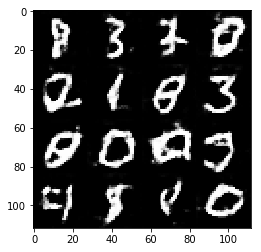

Step 810, (Epoch 1/2)... Discriminator Loss: 1.1046... Generator Loss: 0.6393
Step 820, (Epoch 1/2)... Discriminator Loss: 1.6930... Generator Loss: 1.8044
Step 830, (Epoch 1/2)... Discriminator Loss: 1.1096... Generator Loss: 0.5970
Step 840, (Epoch 1/2)... Discriminator Loss: 1.2222... Generator Loss: 0.6048
Step 850, (Epoch 1/2)... Discriminator Loss: 1.2529... Generator Loss: 0.4643
Step 860, (Epoch 1/2)... Discriminator Loss: 1.2259... Generator Loss: 0.4973
Step 870, (Epoch 1/2)... Discriminator Loss: 2.5503... Generator Loss: 0.1123
Step 880, (Epoch 1/2)... Discriminator Loss: 1.0865... Generator Loss: 0.8111
Step 890, (Epoch 1/2)... Discriminator Loss: 1.1729... Generator Loss: 0.5589
Step 900, (Epoch 1/2)... Discriminator Loss: 1.2286... Generator Loss: 0.8107


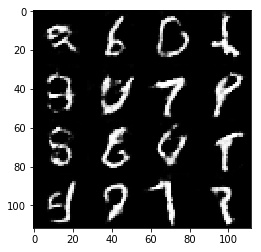

Step 910, (Epoch 1/2)... Discriminator Loss: 0.9890... Generator Loss: 0.7757
Step 920, (Epoch 1/2)... Discriminator Loss: 1.2566... Generator Loss: 0.5580
Step 930, (Epoch 1/2)... Discriminator Loss: 1.0590... Generator Loss: 0.8730
Step 940, (Epoch 2/2)... Discriminator Loss: 1.1583... Generator Loss: 0.7410
Step 950, (Epoch 2/2)... Discriminator Loss: 1.4078... Generator Loss: 0.3915
Step 960, (Epoch 2/2)... Discriminator Loss: 1.4908... Generator Loss: 0.3421
Step 970, (Epoch 2/2)... Discriminator Loss: 1.1408... Generator Loss: 0.7910
Step 980, (Epoch 2/2)... Discriminator Loss: 2.1843... Generator Loss: 0.1884
Step 990, (Epoch 2/2)... Discriminator Loss: 1.1086... Generator Loss: 0.6016
Step 1000, (Epoch 2/2)... Discriminator Loss: 1.2177... Generator Loss: 0.6056


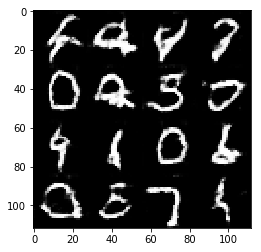

Step 1010, (Epoch 2/2)... Discriminator Loss: 1.1497... Generator Loss: 0.7228
Step 1020, (Epoch 2/2)... Discriminator Loss: 1.5372... Generator Loss: 0.4490
Step 1030, (Epoch 2/2)... Discriminator Loss: 1.1833... Generator Loss: 0.6421
Step 1040, (Epoch 2/2)... Discriminator Loss: 1.5540... Generator Loss: 0.3193
Step 1050, (Epoch 2/2)... Discriminator Loss: 1.0678... Generator Loss: 1.3229
Step 1060, (Epoch 2/2)... Discriminator Loss: 1.2326... Generator Loss: 0.5527
Step 1070, (Epoch 2/2)... Discriminator Loss: 1.5805... Generator Loss: 0.3368
Step 1080, (Epoch 2/2)... Discriminator Loss: 1.5798... Generator Loss: 0.3320
Step 1090, (Epoch 2/2)... Discriminator Loss: 1.1788... Generator Loss: 1.3898
Step 1100, (Epoch 2/2)... Discriminator Loss: 0.9402... Generator Loss: 0.8511


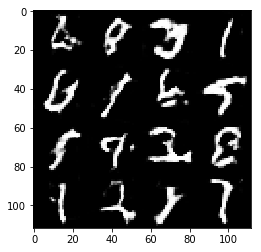

Step 1110, (Epoch 2/2)... Discriminator Loss: 1.3253... Generator Loss: 0.5037
Step 1120, (Epoch 2/2)... Discriminator Loss: 1.2135... Generator Loss: 0.5704
Step 1130, (Epoch 2/2)... Discriminator Loss: 1.5075... Generator Loss: 0.3441
Step 1140, (Epoch 2/2)... Discriminator Loss: 1.4127... Generator Loss: 0.4807
Step 1150, (Epoch 2/2)... Discriminator Loss: 0.8508... Generator Loss: 1.4754
Step 1160, (Epoch 2/2)... Discriminator Loss: 1.1332... Generator Loss: 1.0678
Step 1170, (Epoch 2/2)... Discriminator Loss: 1.3213... Generator Loss: 0.4608
Step 1180, (Epoch 2/2)... Discriminator Loss: 1.1700... Generator Loss: 1.3340
Step 1190, (Epoch 2/2)... Discriminator Loss: 1.3430... Generator Loss: 0.4301
Step 1200, (Epoch 2/2)... Discriminator Loss: 1.3907... Generator Loss: 0.4349


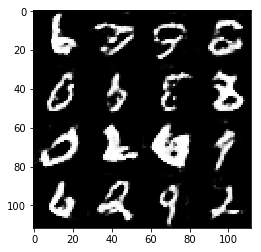

Step 1210, (Epoch 2/2)... Discriminator Loss: 1.5228... Generator Loss: 1.8189
Step 1220, (Epoch 2/2)... Discriminator Loss: 0.9390... Generator Loss: 0.9117
Step 1230, (Epoch 2/2)... Discriminator Loss: 1.0456... Generator Loss: 0.6741
Step 1240, (Epoch 2/2)... Discriminator Loss: 1.3900... Generator Loss: 0.4666
Step 1250, (Epoch 2/2)... Discriminator Loss: 1.4170... Generator Loss: 0.4439
Step 1260, (Epoch 2/2)... Discriminator Loss: 1.4629... Generator Loss: 0.3821
Step 1270, (Epoch 2/2)... Discriminator Loss: 1.1002... Generator Loss: 1.3142
Step 1280, (Epoch 2/2)... Discriminator Loss: 1.3443... Generator Loss: 0.5298
Step 1290, (Epoch 2/2)... Discriminator Loss: 1.3589... Generator Loss: 0.4011
Step 1300, (Epoch 2/2)... Discriminator Loss: 1.6737... Generator Loss: 0.9412


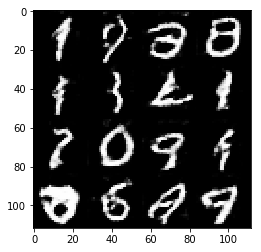

Step 1310, (Epoch 2/2)... Discriminator Loss: 1.3697... Generator Loss: 0.4193
Step 1320, (Epoch 2/2)... Discriminator Loss: 1.6630... Generator Loss: 0.2846
Step 1330, (Epoch 2/2)... Discriminator Loss: 0.9444... Generator Loss: 1.4033
Step 1340, (Epoch 2/2)... Discriminator Loss: 1.0256... Generator Loss: 0.7465
Step 1350, (Epoch 2/2)... Discriminator Loss: 2.4382... Generator Loss: 3.3941
Step 1360, (Epoch 2/2)... Discriminator Loss: 1.2137... Generator Loss: 0.5896
Step 1370, (Epoch 2/2)... Discriminator Loss: 1.3030... Generator Loss: 0.5510
Step 1380, (Epoch 2/2)... Discriminator Loss: 1.3308... Generator Loss: 0.4564
Step 1390, (Epoch 2/2)... Discriminator Loss: 0.8730... Generator Loss: 0.8885
Step 1400, (Epoch 2/2)... Discriminator Loss: 1.2540... Generator Loss: 0.7942


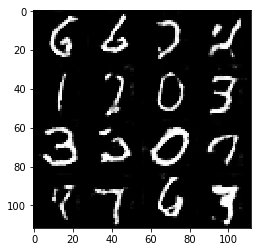

Step 1410, (Epoch 2/2)... Discriminator Loss: 1.9505... Generator Loss: 0.2129
Step 1420, (Epoch 2/2)... Discriminator Loss: 1.7812... Generator Loss: 0.2405
Step 1430, (Epoch 2/2)... Discriminator Loss: 1.1268... Generator Loss: 0.5642
Step 1440, (Epoch 2/2)... Discriminator Loss: 1.2888... Generator Loss: 0.4425
Step 1450, (Epoch 2/2)... Discriminator Loss: 1.1540... Generator Loss: 0.5822
Step 1460, (Epoch 2/2)... Discriminator Loss: 1.2958... Generator Loss: 0.4489
Step 1470, (Epoch 2/2)... Discriminator Loss: 1.7612... Generator Loss: 0.2562
Step 1480, (Epoch 2/2)... Discriminator Loss: 1.6801... Generator Loss: 0.2952
Step 1490, (Epoch 2/2)... Discriminator Loss: 0.9511... Generator Loss: 1.1853
Step 1500, (Epoch 2/2)... Discriminator Loss: 1.4473... Generator Loss: 0.3824


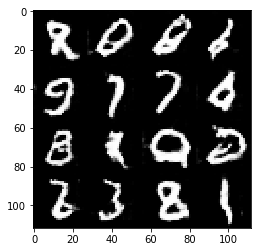

Step 1510, (Epoch 2/2)... Discriminator Loss: 1.2707... Generator Loss: 1.1023
Step 1520, (Epoch 2/2)... Discriminator Loss: 0.9147... Generator Loss: 1.2734
Step 1530, (Epoch 2/2)... Discriminator Loss: 0.9278... Generator Loss: 1.2117
Step 1540, (Epoch 2/2)... Discriminator Loss: 1.5716... Generator Loss: 0.6460
Step 1550, (Epoch 2/2)... Discriminator Loss: 1.5528... Generator Loss: 0.3592
Step 1560, (Epoch 2/2)... Discriminator Loss: 1.1005... Generator Loss: 0.6558
Step 1570, (Epoch 2/2)... Discriminator Loss: 1.7011... Generator Loss: 0.2910
Step 1580, (Epoch 2/2)... Discriminator Loss: 1.3934... Generator Loss: 0.4397
Step 1590, (Epoch 2/2)... Discriminator Loss: 1.6685... Generator Loss: 0.3207
Step 1600, (Epoch 2/2)... Discriminator Loss: 1.2350... Generator Loss: 0.5233


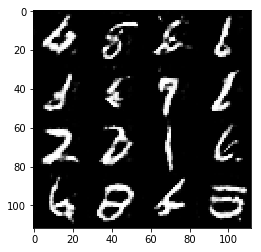

Step 1610, (Epoch 2/2)... Discriminator Loss: 1.6756... Generator Loss: 0.2842
Step 1620, (Epoch 2/2)... Discriminator Loss: 1.5071... Generator Loss: 0.3259
Step 1630, (Epoch 2/2)... Discriminator Loss: 1.6778... Generator Loss: 0.3033
Step 1640, (Epoch 2/2)... Discriminator Loss: 1.8173... Generator Loss: 0.2532
Step 1650, (Epoch 2/2)... Discriminator Loss: 1.5042... Generator Loss: 0.3663
Step 1660, (Epoch 2/2)... Discriminator Loss: 1.5793... Generator Loss: 0.4347
Step 1670, (Epoch 2/2)... Discriminator Loss: 1.4828... Generator Loss: 0.3958
Step 1680, (Epoch 2/2)... Discriminator Loss: 1.8400... Generator Loss: 0.2414
Step 1690, (Epoch 2/2)... Discriminator Loss: 0.9628... Generator Loss: 0.7091
Step 1700, (Epoch 2/2)... Discriminator Loss: 1.5176... Generator Loss: 0.3807


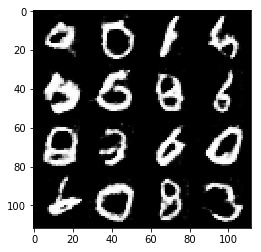

Step 1710, (Epoch 2/2)... Discriminator Loss: 2.0095... Generator Loss: 0.1809
Step 1720, (Epoch 2/2)... Discriminator Loss: 1.6588... Generator Loss: 0.2966
Step 1730, (Epoch 2/2)... Discriminator Loss: 2.1263... Generator Loss: 0.1910
Step 1740, (Epoch 2/2)... Discriminator Loss: 0.8820... Generator Loss: 1.0464
Step 1750, (Epoch 2/2)... Discriminator Loss: 1.3305... Generator Loss: 0.4610
Step 1760, (Epoch 2/2)... Discriminator Loss: 2.1079... Generator Loss: 0.1698
Step 1770, (Epoch 2/2)... Discriminator Loss: 1.5129... Generator Loss: 0.3438
Step 1780, (Epoch 2/2)... Discriminator Loss: 1.3012... Generator Loss: 0.4610
Step 1790, (Epoch 2/2)... Discriminator Loss: 1.5207... Generator Loss: 0.4018
Step 1800, (Epoch 2/2)... Discriminator Loss: 1.6059... Generator Loss: 0.2895


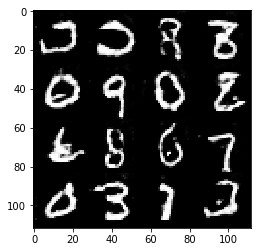

Step 1810, (Epoch 2/2)... Discriminator Loss: 1.4900... Generator Loss: 0.3737
Step 1820, (Epoch 2/2)... Discriminator Loss: 2.7767... Generator Loss: 0.0915
Step 1830, (Epoch 2/2)... Discriminator Loss: 0.9889... Generator Loss: 0.9174
Step 1840, (Epoch 2/2)... Discriminator Loss: 1.2499... Generator Loss: 0.4805
Step 1850, (Epoch 2/2)... Discriminator Loss: 1.5907... Generator Loss: 0.3348
Step 1860, (Epoch 2/2)... Discriminator Loss: 1.0739... Generator Loss: 0.7003
Step 1870, (Epoch 2/2)... Discriminator Loss: 1.0123... Generator Loss: 0.7132


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 10, (Epoch 1/1)... Discriminator Loss: 1.5332... Generator Loss: 3.9709
Step 20, (Epoch 1/1)... Discriminator Loss: 2.1922... Generator Loss: 1.3108
Step 30, (Epoch 1/1)... Discriminator Loss: 2.7283... Generator Loss: 0.3785
Step 40, (Epoch 1/1)... Discriminator Loss: 1.6422... Generator Loss: 0.6320
Step 50, (Epoch 1/1)... Discriminator Loss: 1.3465... Generator Loss: 0.6339
Step 60, (Epoch 1/1)... Discriminator Loss: 1.1858... Generator Loss: 1.3265
Step 70, (Epoch 1/1)... Discriminator Loss: 1.4326... Generator Loss: 0.7547
Step 80, (Epoch 1/1)... Discriminator Loss: 1.2007... Generator Loss: 1.0183
Step 90, (Epoch 1/1)... Discriminator Loss: 2.0572... Generator Loss: 0.2540
Step 100, (Epoch 1/1)... Discriminator Loss: 1.3371... Generator Loss: 0.6807


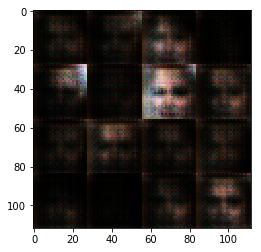

Step 110, (Epoch 1/1)... Discriminator Loss: 1.9096... Generator Loss: 0.4572
Step 120, (Epoch 1/1)... Discriminator Loss: 1.6793... Generator Loss: 0.3691
Step 130, (Epoch 1/1)... Discriminator Loss: 1.5123... Generator Loss: 0.5493
Step 140, (Epoch 1/1)... Discriminator Loss: 1.3641... Generator Loss: 0.8316
Step 150, (Epoch 1/1)... Discriminator Loss: 1.4398... Generator Loss: 1.5730
Step 160, (Epoch 1/1)... Discriminator Loss: 2.0327... Generator Loss: 0.7913
Step 170, (Epoch 1/1)... Discriminator Loss: 1.2434... Generator Loss: 0.9365
Step 180, (Epoch 1/1)... Discriminator Loss: 1.2614... Generator Loss: 1.5396
Step 190, (Epoch 1/1)... Discriminator Loss: 1.6221... Generator Loss: 0.9369
Step 200, (Epoch 1/1)... Discriminator Loss: 1.6248... Generator Loss: 0.5288


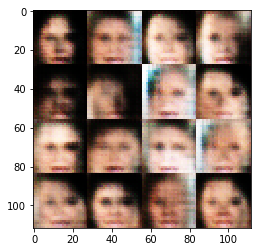

Step 210, (Epoch 1/1)... Discriminator Loss: 1.3016... Generator Loss: 1.0794
Step 220, (Epoch 1/1)... Discriminator Loss: 1.4206... Generator Loss: 0.8075
Step 230, (Epoch 1/1)... Discriminator Loss: 1.1645... Generator Loss: 1.4350
Step 240, (Epoch 1/1)... Discriminator Loss: 1.7036... Generator Loss: 0.6637
Step 250, (Epoch 1/1)... Discriminator Loss: 1.5670... Generator Loss: 0.6516
Step 260, (Epoch 1/1)... Discriminator Loss: 1.4385... Generator Loss: 1.0465
Step 270, (Epoch 1/1)... Discriminator Loss: 1.9750... Generator Loss: 2.6820
Step 280, (Epoch 1/1)... Discriminator Loss: 1.6703... Generator Loss: 0.9694
Step 290, (Epoch 1/1)... Discriminator Loss: 1.6312... Generator Loss: 0.7676
Step 300, (Epoch 1/1)... Discriminator Loss: 1.4847... Generator Loss: 0.5258


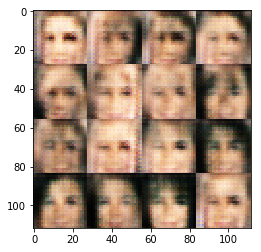

Step 310, (Epoch 1/1)... Discriminator Loss: 1.1921... Generator Loss: 0.8146
Step 320, (Epoch 1/1)... Discriminator Loss: 1.2964... Generator Loss: 0.9419
Step 330, (Epoch 1/1)... Discriminator Loss: 1.6715... Generator Loss: 0.6964
Step 340, (Epoch 1/1)... Discriminator Loss: 1.5883... Generator Loss: 0.7577
Step 350, (Epoch 1/1)... Discriminator Loss: 1.5183... Generator Loss: 0.7048
Step 360, (Epoch 1/1)... Discriminator Loss: 1.5631... Generator Loss: 1.1710
Step 370, (Epoch 1/1)... Discriminator Loss: 1.5061... Generator Loss: 0.7485
Step 380, (Epoch 1/1)... Discriminator Loss: 1.4716... Generator Loss: 0.7744
Step 390, (Epoch 1/1)... Discriminator Loss: 1.5418... Generator Loss: 0.7982
Step 400, (Epoch 1/1)... Discriminator Loss: 1.6028... Generator Loss: 0.6971


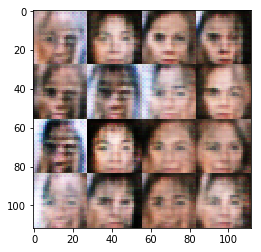

Step 410, (Epoch 1/1)... Discriminator Loss: 1.5712... Generator Loss: 0.5764
Step 420, (Epoch 1/1)... Discriminator Loss: 1.5374... Generator Loss: 1.0024
Step 430, (Epoch 1/1)... Discriminator Loss: 1.5081... Generator Loss: 0.9402
Step 440, (Epoch 1/1)... Discriminator Loss: 1.6138... Generator Loss: 0.4749
Step 450, (Epoch 1/1)... Discriminator Loss: 1.9600... Generator Loss: 0.6633
Step 460, (Epoch 1/1)... Discriminator Loss: 1.8075... Generator Loss: 0.8815
Step 470, (Epoch 1/1)... Discriminator Loss: 1.3644... Generator Loss: 0.8268
Step 480, (Epoch 1/1)... Discriminator Loss: 1.5592... Generator Loss: 0.6977
Step 490, (Epoch 1/1)... Discriminator Loss: 1.6728... Generator Loss: 0.6528
Step 500, (Epoch 1/1)... Discriminator Loss: 1.2996... Generator Loss: 0.9930


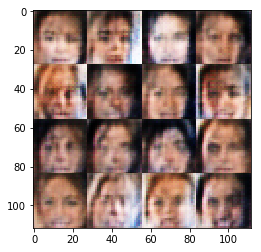

Step 510, (Epoch 1/1)... Discriminator Loss: 1.5777... Generator Loss: 0.6288
Step 520, (Epoch 1/1)... Discriminator Loss: 1.5557... Generator Loss: 0.6400
Step 530, (Epoch 1/1)... Discriminator Loss: 1.3314... Generator Loss: 0.6026
Step 540, (Epoch 1/1)... Discriminator Loss: 1.5295... Generator Loss: 0.7107
Step 550, (Epoch 1/1)... Discriminator Loss: 1.5866... Generator Loss: 0.7735
Step 560, (Epoch 1/1)... Discriminator Loss: 1.5760... Generator Loss: 1.0098
Step 570, (Epoch 1/1)... Discriminator Loss: 1.4112... Generator Loss: 0.9157
Step 580, (Epoch 1/1)... Discriminator Loss: 1.7762... Generator Loss: 0.5148
Step 590, (Epoch 1/1)... Discriminator Loss: 1.6255... Generator Loss: 0.7192
Step 600, (Epoch 1/1)... Discriminator Loss: 1.2432... Generator Loss: 1.0032


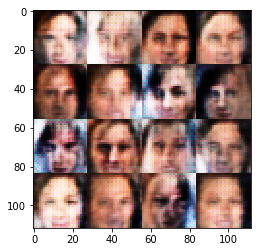

Step 610, (Epoch 1/1)... Discriminator Loss: 1.5344... Generator Loss: 0.6382
Step 620, (Epoch 1/1)... Discriminator Loss: 1.7962... Generator Loss: 0.7115
Step 630, (Epoch 1/1)... Discriminator Loss: 1.8084... Generator Loss: 0.6661
Step 640, (Epoch 1/1)... Discriminator Loss: 1.5262... Generator Loss: 0.7584
Step 650, (Epoch 1/1)... Discriminator Loss: 1.4383... Generator Loss: 0.8501
Step 660, (Epoch 1/1)... Discriminator Loss: 1.7857... Generator Loss: 0.6074
Step 670, (Epoch 1/1)... Discriminator Loss: 1.5398... Generator Loss: 0.6725
Step 680, (Epoch 1/1)... Discriminator Loss: 1.4966... Generator Loss: 0.7631
Step 690, (Epoch 1/1)... Discriminator Loss: 1.3229... Generator Loss: 0.7884
Step 700, (Epoch 1/1)... Discriminator Loss: 1.4554... Generator Loss: 0.8954


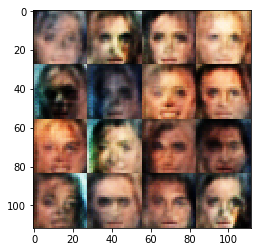

Step 710, (Epoch 1/1)... Discriminator Loss: 1.5195... Generator Loss: 0.7340
Step 720, (Epoch 1/1)... Discriminator Loss: 1.4356... Generator Loss: 0.6231
Step 730, (Epoch 1/1)... Discriminator Loss: 1.5170... Generator Loss: 1.0580
Step 740, (Epoch 1/1)... Discriminator Loss: 1.3872... Generator Loss: 0.7754
Step 750, (Epoch 1/1)... Discriminator Loss: 1.4466... Generator Loss: 0.9071
Step 760, (Epoch 1/1)... Discriminator Loss: 1.8433... Generator Loss: 0.5713
Step 770, (Epoch 1/1)... Discriminator Loss: 1.4359... Generator Loss: 0.6128
Step 780, (Epoch 1/1)... Discriminator Loss: 1.6025... Generator Loss: 0.9382
Step 790, (Epoch 1/1)... Discriminator Loss: 1.4833... Generator Loss: 0.7809
Step 800, (Epoch 1/1)... Discriminator Loss: 1.3907... Generator Loss: 0.7107


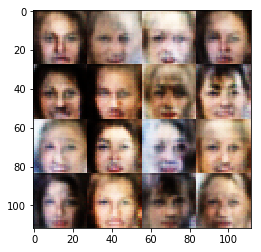

Step 810, (Epoch 1/1)... Discriminator Loss: 1.4396... Generator Loss: 0.5808
Step 820, (Epoch 1/1)... Discriminator Loss: 1.4767... Generator Loss: 0.8239
Step 830, (Epoch 1/1)... Discriminator Loss: 1.3802... Generator Loss: 0.7280
Step 840, (Epoch 1/1)... Discriminator Loss: 1.4718... Generator Loss: 0.7549
Step 850, (Epoch 1/1)... Discriminator Loss: 1.4569... Generator Loss: 0.6511
Step 860, (Epoch 1/1)... Discriminator Loss: 1.4596... Generator Loss: 0.5634
Step 870, (Epoch 1/1)... Discriminator Loss: 1.5045... Generator Loss: 0.7860
Step 880, (Epoch 1/1)... Discriminator Loss: 1.4956... Generator Loss: 0.6969
Step 890, (Epoch 1/1)... Discriminator Loss: 1.4906... Generator Loss: 1.0956
Step 900, (Epoch 1/1)... Discriminator Loss: 1.6787... Generator Loss: 0.4558


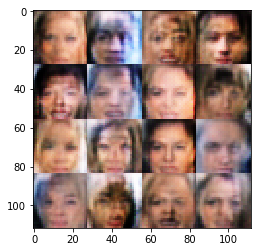

Step 910, (Epoch 1/1)... Discriminator Loss: 1.5712... Generator Loss: 0.6374
Step 920, (Epoch 1/1)... Discriminator Loss: 1.5648... Generator Loss: 0.5772
Step 930, (Epoch 1/1)... Discriminator Loss: 1.4709... Generator Loss: 0.7040
Step 940, (Epoch 1/1)... Discriminator Loss: 1.5444... Generator Loss: 1.2076
Step 950, (Epoch 1/1)... Discriminator Loss: 1.5001... Generator Loss: 0.6307
Step 960, (Epoch 1/1)... Discriminator Loss: 1.5963... Generator Loss: 0.6524
Step 970, (Epoch 1/1)... Discriminator Loss: 1.4487... Generator Loss: 0.9107
Step 980, (Epoch 1/1)... Discriminator Loss: 1.3955... Generator Loss: 0.5751
Step 990, (Epoch 1/1)... Discriminator Loss: 1.5272... Generator Loss: 0.7282
Step 1000, (Epoch 1/1)... Discriminator Loss: 1.5179... Generator Loss: 0.6087


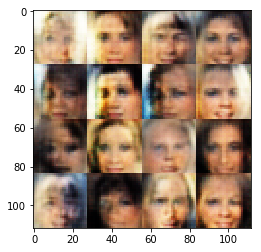

Step 1010, (Epoch 1/1)... Discriminator Loss: 1.5268... Generator Loss: 0.7286
Step 1020, (Epoch 1/1)... Discriminator Loss: 1.5007... Generator Loss: 0.8721
Step 1030, (Epoch 1/1)... Discriminator Loss: 1.5002... Generator Loss: 0.7742
Step 1040, (Epoch 1/1)... Discriminator Loss: 1.5234... Generator Loss: 0.9379
Step 1050, (Epoch 1/1)... Discriminator Loss: 1.5495... Generator Loss: 0.7139
Step 1060, (Epoch 1/1)... Discriminator Loss: 1.4947... Generator Loss: 0.6294
Step 1070, (Epoch 1/1)... Discriminator Loss: 1.6429... Generator Loss: 0.7337
Step 1080, (Epoch 1/1)... Discriminator Loss: 1.3296... Generator Loss: 0.9449
Step 1090, (Epoch 1/1)... Discriminator Loss: 1.5640... Generator Loss: 0.7374
Step 1100, (Epoch 1/1)... Discriminator Loss: 1.3920... Generator Loss: 0.9107


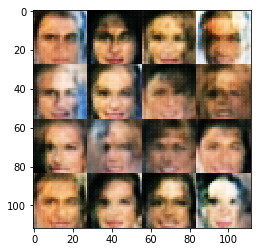

Step 1110, (Epoch 1/1)... Discriminator Loss: 1.3992... Generator Loss: 0.7424
Step 1120, (Epoch 1/1)... Discriminator Loss: 1.5850... Generator Loss: 0.6798
Step 1130, (Epoch 1/1)... Discriminator Loss: 1.5394... Generator Loss: 0.7013
Step 1140, (Epoch 1/1)... Discriminator Loss: 1.4674... Generator Loss: 0.7506
Step 1150, (Epoch 1/1)... Discriminator Loss: 1.4495... Generator Loss: 0.7283
Step 1160, (Epoch 1/1)... Discriminator Loss: 1.5324... Generator Loss: 0.6115
Step 1170, (Epoch 1/1)... Discriminator Loss: 1.4591... Generator Loss: 0.6725
Step 1180, (Epoch 1/1)... Discriminator Loss: 1.4078... Generator Loss: 0.8454
Step 1190, (Epoch 1/1)... Discriminator Loss: 1.5067... Generator Loss: 0.8084
Step 1200, (Epoch 1/1)... Discriminator Loss: 1.4122... Generator Loss: 0.8445


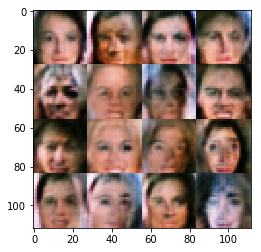

Step 1210, (Epoch 1/1)... Discriminator Loss: 1.4594... Generator Loss: 0.8213
Step 1220, (Epoch 1/1)... Discriminator Loss: 1.5136... Generator Loss: 0.7926
Step 1230, (Epoch 1/1)... Discriminator Loss: 1.5233... Generator Loss: 0.7077
Step 1240, (Epoch 1/1)... Discriminator Loss: 1.4506... Generator Loss: 0.6464
Step 1250, (Epoch 1/1)... Discriminator Loss: 1.5573... Generator Loss: 0.6920
Step 1260, (Epoch 1/1)... Discriminator Loss: 1.4799... Generator Loss: 0.8222
Step 1270, (Epoch 1/1)... Discriminator Loss: 1.3254... Generator Loss: 0.6968
Step 1280, (Epoch 1/1)... Discriminator Loss: 1.3551... Generator Loss: 0.8191
Step 1290, (Epoch 1/1)... Discriminator Loss: 1.2793... Generator Loss: 0.7499
Step 1300, (Epoch 1/1)... Discriminator Loss: 1.3992... Generator Loss: 0.8995


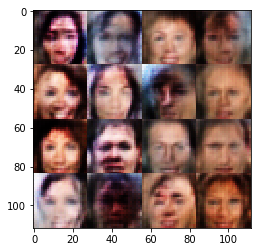

Step 1310, (Epoch 1/1)... Discriminator Loss: 1.2306... Generator Loss: 0.9426
Step 1320, (Epoch 1/1)... Discriminator Loss: 1.5675... Generator Loss: 0.7278
Step 1330, (Epoch 1/1)... Discriminator Loss: 1.4963... Generator Loss: 0.8197
Step 1340, (Epoch 1/1)... Discriminator Loss: 1.6061... Generator Loss: 0.5607
Step 1350, (Epoch 1/1)... Discriminator Loss: 1.4778... Generator Loss: 0.7104
Step 1360, (Epoch 1/1)... Discriminator Loss: 1.5555... Generator Loss: 0.8939
Step 1370, (Epoch 1/1)... Discriminator Loss: 1.4777... Generator Loss: 0.7622
Step 1380, (Epoch 1/1)... Discriminator Loss: 1.4732... Generator Loss: 0.6233
Step 1390, (Epoch 1/1)... Discriminator Loss: 1.5940... Generator Loss: 0.4844
Step 1400, (Epoch 1/1)... Discriminator Loss: 1.3726... Generator Loss: 1.0142


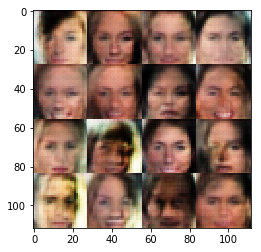

Step 1410, (Epoch 1/1)... Discriminator Loss: 1.6342... Generator Loss: 1.0415
Step 1420, (Epoch 1/1)... Discriminator Loss: 1.4081... Generator Loss: 0.7968
Step 1430, (Epoch 1/1)... Discriminator Loss: 1.3033... Generator Loss: 0.8521
Step 1440, (Epoch 1/1)... Discriminator Loss: 1.5745... Generator Loss: 0.7253
Step 1450, (Epoch 1/1)... Discriminator Loss: 1.5184... Generator Loss: 0.9174
Step 1460, (Epoch 1/1)... Discriminator Loss: 1.3680... Generator Loss: 0.7806
Step 1470, (Epoch 1/1)... Discriminator Loss: 1.3900... Generator Loss: 0.7747
Step 1480, (Epoch 1/1)... Discriminator Loss: 1.4416... Generator Loss: 0.7803
Step 1490, (Epoch 1/1)... Discriminator Loss: 1.4393... Generator Loss: 0.7559
Step 1500, (Epoch 1/1)... Discriminator Loss: 1.4628... Generator Loss: 0.8365


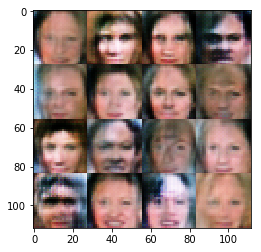

Step 1510, (Epoch 1/1)... Discriminator Loss: 1.4919... Generator Loss: 0.6630
Step 1520, (Epoch 1/1)... Discriminator Loss: 1.4373... Generator Loss: 0.9627
Step 1530, (Epoch 1/1)... Discriminator Loss: 1.5845... Generator Loss: 0.7392
Step 1540, (Epoch 1/1)... Discriminator Loss: 1.4134... Generator Loss: 0.6138
Step 1550, (Epoch 1/1)... Discriminator Loss: 1.2753... Generator Loss: 0.9028
Step 1560, (Epoch 1/1)... Discriminator Loss: 1.4285... Generator Loss: 0.7845
Step 1570, (Epoch 1/1)... Discriminator Loss: 1.3694... Generator Loss: 0.7075
Step 1580, (Epoch 1/1)... Discriminator Loss: 1.3506... Generator Loss: 0.8580
Step 1590, (Epoch 1/1)... Discriminator Loss: 1.2524... Generator Loss: 0.9322
Step 1600, (Epoch 1/1)... Discriminator Loss: 1.5362... Generator Loss: 0.9665


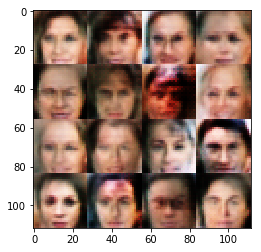

Step 1610, (Epoch 1/1)... Discriminator Loss: 1.5137... Generator Loss: 0.5964
Step 1620, (Epoch 1/1)... Discriminator Loss: 1.5440... Generator Loss: 0.7188
Step 1630, (Epoch 1/1)... Discriminator Loss: 1.4592... Generator Loss: 0.9149
Step 1640, (Epoch 1/1)... Discriminator Loss: 1.4305... Generator Loss: 0.6665
Step 1650, (Epoch 1/1)... Discriminator Loss: 1.4617... Generator Loss: 0.6832
Step 1660, (Epoch 1/1)... Discriminator Loss: 1.4525... Generator Loss: 0.6763
Step 1670, (Epoch 1/1)... Discriminator Loss: 1.3733... Generator Loss: 0.7331
Step 1680, (Epoch 1/1)... Discriminator Loss: 1.4369... Generator Loss: 0.9007
Step 1690, (Epoch 1/1)... Discriminator Loss: 1.7194... Generator Loss: 0.6158
Step 1700, (Epoch 1/1)... Discriminator Loss: 1.2941... Generator Loss: 0.7796


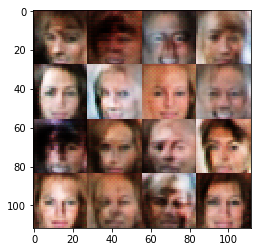

Step 1710, (Epoch 1/1)... Discriminator Loss: 1.4023... Generator Loss: 0.7807
Step 1720, (Epoch 1/1)... Discriminator Loss: 1.7557... Generator Loss: 0.4108
Step 1730, (Epoch 1/1)... Discriminator Loss: 1.5020... Generator Loss: 0.6752
Step 1740, (Epoch 1/1)... Discriminator Loss: 1.4822... Generator Loss: 0.7877
Step 1750, (Epoch 1/1)... Discriminator Loss: 1.5227... Generator Loss: 0.5412
Step 1760, (Epoch 1/1)... Discriminator Loss: 1.4668... Generator Loss: 0.8166
Step 1770, (Epoch 1/1)... Discriminator Loss: 1.4973... Generator Loss: 0.7959
Step 1780, (Epoch 1/1)... Discriminator Loss: 1.4461... Generator Loss: 0.7642
Step 1790, (Epoch 1/1)... Discriminator Loss: 1.5071... Generator Loss: 0.9762
Step 1800, (Epoch 1/1)... Discriminator Loss: 1.5972... Generator Loss: 0.4918


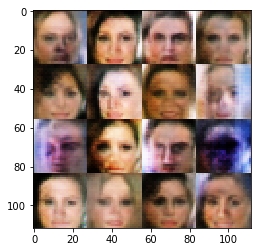

Step 1810, (Epoch 1/1)... Discriminator Loss: 1.4449... Generator Loss: 0.9507
Step 1820, (Epoch 1/1)... Discriminator Loss: 1.5878... Generator Loss: 0.9870
Step 1830, (Epoch 1/1)... Discriminator Loss: 1.4206... Generator Loss: 0.5782
Step 1840, (Epoch 1/1)... Discriminator Loss: 1.5483... Generator Loss: 0.6339
Step 1850, (Epoch 1/1)... Discriminator Loss: 1.4904... Generator Loss: 0.7457
Step 1860, (Epoch 1/1)... Discriminator Loss: 1.5875... Generator Loss: 0.5520
Step 1870, (Epoch 1/1)... Discriminator Loss: 1.4885... Generator Loss: 0.8977
Step 1880, (Epoch 1/1)... Discriminator Loss: 1.4648... Generator Loss: 0.5553
Step 1890, (Epoch 1/1)... Discriminator Loss: 1.4532... Generator Loss: 0.5972
Step 1900, (Epoch 1/1)... Discriminator Loss: 1.5805... Generator Loss: 0.6826


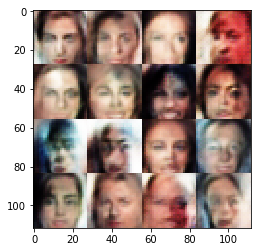

Step 1910, (Epoch 1/1)... Discriminator Loss: 1.3966... Generator Loss: 0.8941
Step 1920, (Epoch 1/1)... Discriminator Loss: 1.4343... Generator Loss: 0.7485
Step 1930, (Epoch 1/1)... Discriminator Loss: 1.5896... Generator Loss: 0.5002
Step 1940, (Epoch 1/1)... Discriminator Loss: 1.4715... Generator Loss: 0.6238
Step 1950, (Epoch 1/1)... Discriminator Loss: 1.6024... Generator Loss: 0.5356
Step 1960, (Epoch 1/1)... Discriminator Loss: 1.4790... Generator Loss: 0.5880
Step 1970, (Epoch 1/1)... Discriminator Loss: 1.4439... Generator Loss: 0.8877
Step 1980, (Epoch 1/1)... Discriminator Loss: 1.3309... Generator Loss: 0.8038
Step 1990, (Epoch 1/1)... Discriminator Loss: 1.4197... Generator Loss: 0.8043
Step 2000, (Epoch 1/1)... Discriminator Loss: 1.4008... Generator Loss: 0.8871


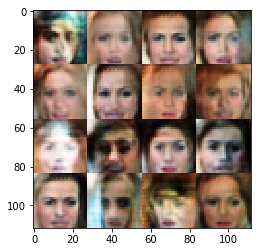

Step 2010, (Epoch 1/1)... Discriminator Loss: 1.4264... Generator Loss: 0.9128
Step 2020, (Epoch 1/1)... Discriminator Loss: 1.3364... Generator Loss: 0.7588
Step 2030, (Epoch 1/1)... Discriminator Loss: 1.5118... Generator Loss: 0.8879
Step 2040, (Epoch 1/1)... Discriminator Loss: 1.4365... Generator Loss: 0.7165
Step 2050, (Epoch 1/1)... Discriminator Loss: 1.8000... Generator Loss: 0.6331
Step 2060, (Epoch 1/1)... Discriminator Loss: 1.4527... Generator Loss: 0.6874
Step 2070, (Epoch 1/1)... Discriminator Loss: 1.3911... Generator Loss: 0.7200
Step 2080, (Epoch 1/1)... Discriminator Loss: 1.3494... Generator Loss: 0.6270
Step 2090, (Epoch 1/1)... Discriminator Loss: 1.3460... Generator Loss: 0.7202
Step 2100, (Epoch 1/1)... Discriminator Loss: 1.3960... Generator Loss: 0.6796


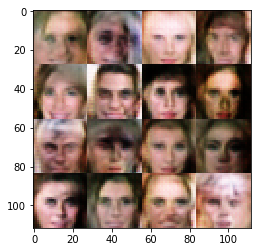

Step 2110, (Epoch 1/1)... Discriminator Loss: 1.5272... Generator Loss: 0.5961
Step 2120, (Epoch 1/1)... Discriminator Loss: 1.5166... Generator Loss: 0.8325
Step 2130, (Epoch 1/1)... Discriminator Loss: 1.5166... Generator Loss: 0.6723
Step 2140, (Epoch 1/1)... Discriminator Loss: 1.4843... Generator Loss: 0.5657
Step 2150, (Epoch 1/1)... Discriminator Loss: 1.3676... Generator Loss: 0.5998
Step 2160, (Epoch 1/1)... Discriminator Loss: 1.4657... Generator Loss: 0.7118
Step 2170, (Epoch 1/1)... Discriminator Loss: 1.4626... Generator Loss: 0.8539
Step 2180, (Epoch 1/1)... Discriminator Loss: 1.4359... Generator Loss: 0.6707
Step 2190, (Epoch 1/1)... Discriminator Loss: 1.4924... Generator Loss: 0.7844
Step 2200, (Epoch 1/1)... Discriminator Loss: 1.3969... Generator Loss: 1.1126


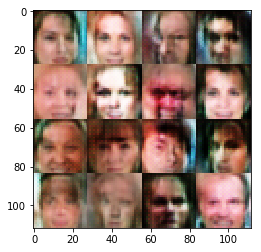

Step 2210, (Epoch 1/1)... Discriminator Loss: 1.4237... Generator Loss: 0.7096
Step 2220, (Epoch 1/1)... Discriminator Loss: 1.4557... Generator Loss: 0.6685
Step 2230, (Epoch 1/1)... Discriminator Loss: 1.3807... Generator Loss: 0.6240
Step 2240, (Epoch 1/1)... Discriminator Loss: 1.4283... Generator Loss: 0.8472
Step 2250, (Epoch 1/1)... Discriminator Loss: 1.3502... Generator Loss: 0.7754
Step 2260, (Epoch 1/1)... Discriminator Loss: 1.4562... Generator Loss: 0.8479
Step 2270, (Epoch 1/1)... Discriminator Loss: 1.5022... Generator Loss: 0.5982
Step 2280, (Epoch 1/1)... Discriminator Loss: 1.3928... Generator Loss: 0.8855
Step 2290, (Epoch 1/1)... Discriminator Loss: 1.5529... Generator Loss: 0.6071
Step 2300, (Epoch 1/1)... Discriminator Loss: 1.4264... Generator Loss: 1.0041


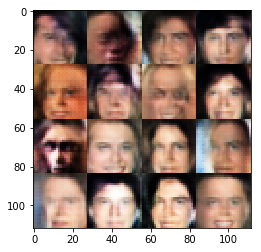

Step 2310, (Epoch 1/1)... Discriminator Loss: 1.4538... Generator Loss: 0.7216
Step 2320, (Epoch 1/1)... Discriminator Loss: 1.4769... Generator Loss: 0.5778
Step 2330, (Epoch 1/1)... Discriminator Loss: 1.2601... Generator Loss: 0.9123
Step 2340, (Epoch 1/1)... Discriminator Loss: 1.2999... Generator Loss: 0.8122
Step 2350, (Epoch 1/1)... Discriminator Loss: 1.3337... Generator Loss: 0.7053
Step 2360, (Epoch 1/1)... Discriminator Loss: 1.5653... Generator Loss: 0.5918
Step 2370, (Epoch 1/1)... Discriminator Loss: 1.4432... Generator Loss: 0.9647
Step 2380, (Epoch 1/1)... Discriminator Loss: 1.3968... Generator Loss: 0.8698
Step 2390, (Epoch 1/1)... Discriminator Loss: 1.4393... Generator Loss: 0.8439
Step 2400, (Epoch 1/1)... Discriminator Loss: 1.4092... Generator Loss: 0.7551


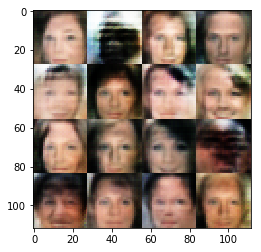

Step 2410, (Epoch 1/1)... Discriminator Loss: 1.5060... Generator Loss: 0.8025
Step 2420, (Epoch 1/1)... Discriminator Loss: 1.3970... Generator Loss: 0.6558
Step 2430, (Epoch 1/1)... Discriminator Loss: 1.5108... Generator Loss: 0.8523
Step 2440, (Epoch 1/1)... Discriminator Loss: 1.3538... Generator Loss: 0.9315
Step 2450, (Epoch 1/1)... Discriminator Loss: 1.3811... Generator Loss: 0.8060
Step 2460, (Epoch 1/1)... Discriminator Loss: 1.4026... Generator Loss: 0.7951
Step 2470, (Epoch 1/1)... Discriminator Loss: 1.3904... Generator Loss: 0.9044
Step 2480, (Epoch 1/1)... Discriminator Loss: 1.2848... Generator Loss: 0.7799
Step 2490, (Epoch 1/1)... Discriminator Loss: 1.4975... Generator Loss: 0.5397
Step 2500, (Epoch 1/1)... Discriminator Loss: 1.5269... Generator Loss: 0.9320


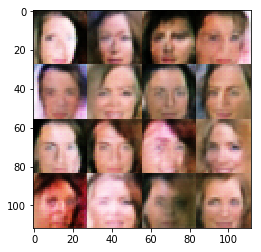

Step 2510, (Epoch 1/1)... Discriminator Loss: 1.3821... Generator Loss: 0.8238
Step 2520, (Epoch 1/1)... Discriminator Loss: 1.5476... Generator Loss: 1.2540
Step 2530, (Epoch 1/1)... Discriminator Loss: 1.3707... Generator Loss: 0.9530
Step 2540, (Epoch 1/1)... Discriminator Loss: 1.3446... Generator Loss: 0.7900
Step 2550, (Epoch 1/1)... Discriminator Loss: 1.1466... Generator Loss: 0.8851
Step 2560, (Epoch 1/1)... Discriminator Loss: 1.5329... Generator Loss: 0.5462
Step 2570, (Epoch 1/1)... Discriminator Loss: 1.5457... Generator Loss: 0.6230
Step 2580, (Epoch 1/1)... Discriminator Loss: 1.5350... Generator Loss: 0.5654
Step 2590, (Epoch 1/1)... Discriminator Loss: 1.5803... Generator Loss: 0.7782
Step 2600, (Epoch 1/1)... Discriminator Loss: 1.3905... Generator Loss: 0.8449


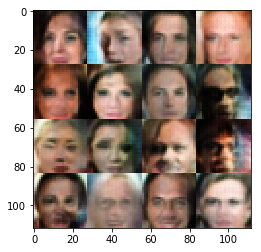

Step 2610, (Epoch 1/1)... Discriminator Loss: 1.4418... Generator Loss: 0.7494
Step 2620, (Epoch 1/1)... Discriminator Loss: 1.2867... Generator Loss: 0.6589
Step 2630, (Epoch 1/1)... Discriminator Loss: 1.4228... Generator Loss: 0.9610
Step 2640, (Epoch 1/1)... Discriminator Loss: 1.2529... Generator Loss: 0.8023
Step 2650, (Epoch 1/1)... Discriminator Loss: 1.3733... Generator Loss: 0.8874
Step 2660, (Epoch 1/1)... Discriminator Loss: 1.3946... Generator Loss: 0.6559
Step 2670, (Epoch 1/1)... Discriminator Loss: 1.5144... Generator Loss: 0.7948
Step 2680, (Epoch 1/1)... Discriminator Loss: 1.4453... Generator Loss: 1.0686
Step 2690, (Epoch 1/1)... Discriminator Loss: 1.3677... Generator Loss: 1.0623
Step 2700, (Epoch 1/1)... Discriminator Loss: 1.5364... Generator Loss: 0.5904


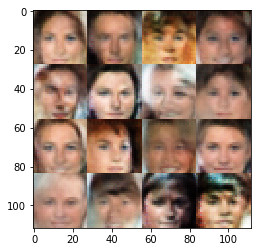

Step 2710, (Epoch 1/1)... Discriminator Loss: 1.3421... Generator Loss: 1.2330
Step 2720, (Epoch 1/1)... Discriminator Loss: 1.4804... Generator Loss: 0.6792
Step 2730, (Epoch 1/1)... Discriminator Loss: 1.5695... Generator Loss: 0.8078
Step 2740, (Epoch 1/1)... Discriminator Loss: 1.3257... Generator Loss: 0.8105
Step 2750, (Epoch 1/1)... Discriminator Loss: 1.4368... Generator Loss: 0.9892
Step 2760, (Epoch 1/1)... Discriminator Loss: 1.2373... Generator Loss: 0.9658
Step 2770, (Epoch 1/1)... Discriminator Loss: 1.3715... Generator Loss: 0.8003
Step 2780, (Epoch 1/1)... Discriminator Loss: 1.4907... Generator Loss: 0.7067
Step 2790, (Epoch 1/1)... Discriminator Loss: 1.4211... Generator Loss: 0.9644
Step 2800, (Epoch 1/1)... Discriminator Loss: 1.4101... Generator Loss: 0.8595


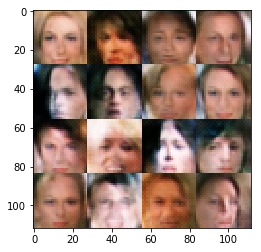

Step 2810, (Epoch 1/1)... Discriminator Loss: 1.4225... Generator Loss: 0.8369
Step 2820, (Epoch 1/1)... Discriminator Loss: 1.3400... Generator Loss: 0.9370
Step 2830, (Epoch 1/1)... Discriminator Loss: 1.3149... Generator Loss: 0.8921
Step 2840, (Epoch 1/1)... Discriminator Loss: 1.2432... Generator Loss: 0.9512
Step 2850, (Epoch 1/1)... Discriminator Loss: 1.3948... Generator Loss: 0.6499
Step 2860, (Epoch 1/1)... Discriminator Loss: 1.5589... Generator Loss: 0.8870
Step 2870, (Epoch 1/1)... Discriminator Loss: 1.3802... Generator Loss: 0.6280
Step 2880, (Epoch 1/1)... Discriminator Loss: 1.4143... Generator Loss: 0.6815
Step 2890, (Epoch 1/1)... Discriminator Loss: 1.6036... Generator Loss: 0.7437
Step 2900, (Epoch 1/1)... Discriminator Loss: 1.7025... Generator Loss: 0.4765


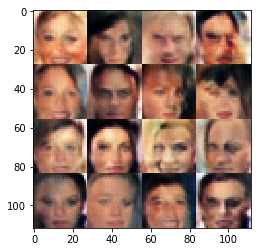

Step 2910, (Epoch 1/1)... Discriminator Loss: 1.3630... Generator Loss: 0.7912
Step 2920, (Epoch 1/1)... Discriminator Loss: 1.3712... Generator Loss: 0.6770
Step 2930, (Epoch 1/1)... Discriminator Loss: 1.3567... Generator Loss: 1.0616
Step 2940, (Epoch 1/1)... Discriminator Loss: 1.4495... Generator Loss: 0.7228
Step 2950, (Epoch 1/1)... Discriminator Loss: 1.5198... Generator Loss: 0.8018
Step 2960, (Epoch 1/1)... Discriminator Loss: 1.3451... Generator Loss: 0.7493
Step 2970, (Epoch 1/1)... Discriminator Loss: 1.3675... Generator Loss: 0.5702
Step 2980, (Epoch 1/1)... Discriminator Loss: 1.6699... Generator Loss: 0.5346
Step 2990, (Epoch 1/1)... Discriminator Loss: 1.4422... Generator Loss: 0.5903
Step 3000, (Epoch 1/1)... Discriminator Loss: 1.3342... Generator Loss: 0.7603


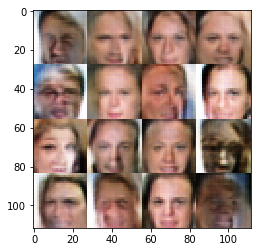

Step 3010, (Epoch 1/1)... Discriminator Loss: 1.3031... Generator Loss: 0.6731
Step 3020, (Epoch 1/1)... Discriminator Loss: 1.2697... Generator Loss: 0.8926
Step 3030, (Epoch 1/1)... Discriminator Loss: 1.4193... Generator Loss: 0.6463
Step 3040, (Epoch 1/1)... Discriminator Loss: 1.4130... Generator Loss: 0.8607
Step 3050, (Epoch 1/1)... Discriminator Loss: 1.5113... Generator Loss: 0.8998
Step 3060, (Epoch 1/1)... Discriminator Loss: 1.3818... Generator Loss: 0.6936
Step 3070, (Epoch 1/1)... Discriminator Loss: 1.6373... Generator Loss: 0.4130
Step 3080, (Epoch 1/1)... Discriminator Loss: 1.5686... Generator Loss: 0.9364
Step 3090, (Epoch 1/1)... Discriminator Loss: 1.3572... Generator Loss: 0.6631
Step 3100, (Epoch 1/1)... Discriminator Loss: 1.4707... Generator Loss: 0.7051


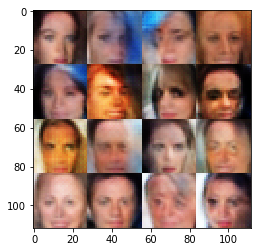

Step 3110, (Epoch 1/1)... Discriminator Loss: 1.4390... Generator Loss: 0.7760
Step 3120, (Epoch 1/1)... Discriminator Loss: 1.5413... Generator Loss: 0.9608
Step 3130, (Epoch 1/1)... Discriminator Loss: 1.4063... Generator Loss: 0.6644
Step 3140, (Epoch 1/1)... Discriminator Loss: 1.3500... Generator Loss: 0.7124
Step 3150, (Epoch 1/1)... Discriminator Loss: 1.3784... Generator Loss: 0.6765
Step 3160, (Epoch 1/1)... Discriminator Loss: 1.6460... Generator Loss: 0.4303
Step 3170, (Epoch 1/1)... Discriminator Loss: 1.2755... Generator Loss: 1.0008
Step 3180, (Epoch 1/1)... Discriminator Loss: 1.3100... Generator Loss: 0.7629
Step 3190, (Epoch 1/1)... Discriminator Loss: 1.4433... Generator Loss: 0.4513
Step 3200, (Epoch 1/1)... Discriminator Loss: 1.5175... Generator Loss: 0.5525


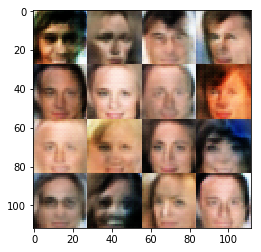

Step 3210, (Epoch 1/1)... Discriminator Loss: 1.3772... Generator Loss: 0.9410
Step 3220, (Epoch 1/1)... Discriminator Loss: 1.3899... Generator Loss: 0.6970
Step 3230, (Epoch 1/1)... Discriminator Loss: 1.4513... Generator Loss: 0.7685
Step 3240, (Epoch 1/1)... Discriminator Loss: 1.2823... Generator Loss: 0.8232
Step 3250, (Epoch 1/1)... Discriminator Loss: 1.4327... Generator Loss: 1.0328
Step 3260, (Epoch 1/1)... Discriminator Loss: 1.2997... Generator Loss: 0.8435
Step 3270, (Epoch 1/1)... Discriminator Loss: 1.5302... Generator Loss: 0.8167
Step 3280, (Epoch 1/1)... Discriminator Loss: 1.4230... Generator Loss: 0.7800
Step 3290, (Epoch 1/1)... Discriminator Loss: 1.4702... Generator Loss: 0.8582
Step 3300, (Epoch 1/1)... Discriminator Loss: 1.4040... Generator Loss: 0.8840


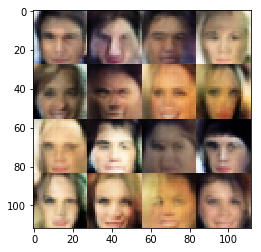

Step 3310, (Epoch 1/1)... Discriminator Loss: 1.3939... Generator Loss: 0.7993
Step 3320, (Epoch 1/1)... Discriminator Loss: 1.3939... Generator Loss: 0.6967
Step 3330, (Epoch 1/1)... Discriminator Loss: 1.3510... Generator Loss: 0.9236
Step 3340, (Epoch 1/1)... Discriminator Loss: 1.4989... Generator Loss: 0.5373
Step 3350, (Epoch 1/1)... Discriminator Loss: 1.4425... Generator Loss: 0.6939
Step 3360, (Epoch 1/1)... Discriminator Loss: 1.4281... Generator Loss: 0.7934
Step 3370, (Epoch 1/1)... Discriminator Loss: 1.4828... Generator Loss: 0.7016
Step 3380, (Epoch 1/1)... Discriminator Loss: 1.3873... Generator Loss: 0.5620
Step 3390, (Epoch 1/1)... Discriminator Loss: 1.2683... Generator Loss: 0.9109
Step 3400, (Epoch 1/1)... Discriminator Loss: 1.4802... Generator Loss: 0.7064


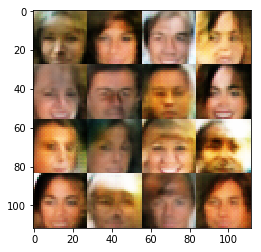

Step 3410, (Epoch 1/1)... Discriminator Loss: 1.4557... Generator Loss: 0.4780
Step 3420, (Epoch 1/1)... Discriminator Loss: 1.2990... Generator Loss: 0.7461
Step 3430, (Epoch 1/1)... Discriminator Loss: 1.4367... Generator Loss: 0.6444
Step 3440, (Epoch 1/1)... Discriminator Loss: 1.4307... Generator Loss: 0.7185
Step 3450, (Epoch 1/1)... Discriminator Loss: 1.4121... Generator Loss: 0.7862
Step 3460, (Epoch 1/1)... Discriminator Loss: 1.3519... Generator Loss: 0.8510
Step 3470, (Epoch 1/1)... Discriminator Loss: 1.5946... Generator Loss: 0.5143
Step 3480, (Epoch 1/1)... Discriminator Loss: 1.4946... Generator Loss: 0.8343
Step 3490, (Epoch 1/1)... Discriminator Loss: 1.3262... Generator Loss: 0.7530
Step 3500, (Epoch 1/1)... Discriminator Loss: 1.3031... Generator Loss: 0.7919


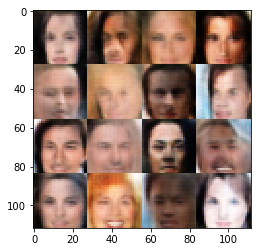

Step 3510, (Epoch 1/1)... Discriminator Loss: 1.4129... Generator Loss: 1.0956
Step 3520, (Epoch 1/1)... Discriminator Loss: 1.3691... Generator Loss: 0.8433
Step 3530, (Epoch 1/1)... Discriminator Loss: 1.4738... Generator Loss: 0.5583
Step 3540, (Epoch 1/1)... Discriminator Loss: 1.5189... Generator Loss: 0.7164
Step 3550, (Epoch 1/1)... Discriminator Loss: 1.5822... Generator Loss: 0.6217
Step 3560, (Epoch 1/1)... Discriminator Loss: 1.5646... Generator Loss: 0.4816
Step 3570, (Epoch 1/1)... Discriminator Loss: 1.3272... Generator Loss: 0.7917
Step 3580, (Epoch 1/1)... Discriminator Loss: 1.4160... Generator Loss: 0.8205
Step 3590, (Epoch 1/1)... Discriminator Loss: 1.3449... Generator Loss: 0.9089
Step 3600, (Epoch 1/1)... Discriminator Loss: 1.2658... Generator Loss: 0.8443


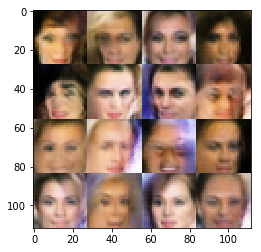

Step 3610, (Epoch 1/1)... Discriminator Loss: 1.4216... Generator Loss: 0.7698
Step 3620, (Epoch 1/1)... Discriminator Loss: 1.4420... Generator Loss: 0.8126
Step 3630, (Epoch 1/1)... Discriminator Loss: 1.4777... Generator Loss: 0.5906
Step 3640, (Epoch 1/1)... Discriminator Loss: 1.3691... Generator Loss: 0.9891
Step 3650, (Epoch 1/1)... Discriminator Loss: 1.2351... Generator Loss: 0.8961
Step 3660, (Epoch 1/1)... Discriminator Loss: 1.1159... Generator Loss: 1.0628
Step 3670, (Epoch 1/1)... Discriminator Loss: 1.3312... Generator Loss: 0.7244
Step 3680, (Epoch 1/1)... Discriminator Loss: 1.3945... Generator Loss: 0.6207
Step 3690, (Epoch 1/1)... Discriminator Loss: 1.4110... Generator Loss: 0.8423
Step 3700, (Epoch 1/1)... Discriminator Loss: 1.3383... Generator Loss: 0.6487


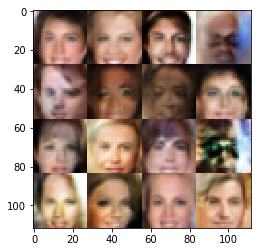

Step 3710, (Epoch 1/1)... Discriminator Loss: 1.5052... Generator Loss: 0.8358
Step 3720, (Epoch 1/1)... Discriminator Loss: 1.2144... Generator Loss: 1.0301
Step 3730, (Epoch 1/1)... Discriminator Loss: 1.4858... Generator Loss: 0.5367
Step 3740, (Epoch 1/1)... Discriminator Loss: 1.5412... Generator Loss: 0.8444
Step 3750, (Epoch 1/1)... Discriminator Loss: 1.4068... Generator Loss: 0.7003
Step 3760, (Epoch 1/1)... Discriminator Loss: 1.3100... Generator Loss: 0.8505
Step 3770, (Epoch 1/1)... Discriminator Loss: 1.3563... Generator Loss: 0.7613
Step 3780, (Epoch 1/1)... Discriminator Loss: 1.4303... Generator Loss: 0.8658
Step 3790, (Epoch 1/1)... Discriminator Loss: 1.2643... Generator Loss: 0.9496
Step 3800, (Epoch 1/1)... Discriminator Loss: 1.4677... Generator Loss: 0.5687


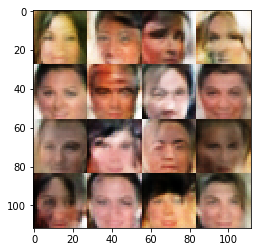

Step 3810, (Epoch 1/1)... Discriminator Loss: 1.4339... Generator Loss: 0.7645
Step 3820, (Epoch 1/1)... Discriminator Loss: 1.4110... Generator Loss: 0.6556
Step 3830, (Epoch 1/1)... Discriminator Loss: 1.4071... Generator Loss: 0.8091
Step 3840, (Epoch 1/1)... Discriminator Loss: 1.5489... Generator Loss: 0.7198
Step 3850, (Epoch 1/1)... Discriminator Loss: 1.2039... Generator Loss: 1.1078
Step 3860, (Epoch 1/1)... Discriminator Loss: 1.5164... Generator Loss: 0.5654
Step 3870, (Epoch 1/1)... Discriminator Loss: 1.5519... Generator Loss: 0.6454
Step 3880, (Epoch 1/1)... Discriminator Loss: 1.4817... Generator Loss: 0.7089
Step 3890, (Epoch 1/1)... Discriminator Loss: 1.2248... Generator Loss: 0.9107
Step 3900, (Epoch 1/1)... Discriminator Loss: 1.5551... Generator Loss: 0.5129


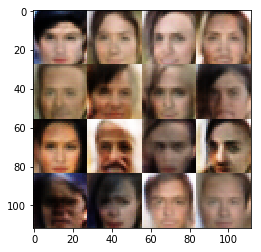

Step 3910, (Epoch 1/1)... Discriminator Loss: 1.4501... Generator Loss: 0.7985
Step 3920, (Epoch 1/1)... Discriminator Loss: 1.3023... Generator Loss: 1.1546
Step 3930, (Epoch 1/1)... Discriminator Loss: 1.3756... Generator Loss: 0.8984
Step 3940, (Epoch 1/1)... Discriminator Loss: 1.3374... Generator Loss: 0.7063
Step 3950, (Epoch 1/1)... Discriminator Loss: 1.3784... Generator Loss: 1.0723
Step 3960, (Epoch 1/1)... Discriminator Loss: 1.1861... Generator Loss: 0.9884
Step 3970, (Epoch 1/1)... Discriminator Loss: 1.1850... Generator Loss: 0.8292
Step 3980, (Epoch 1/1)... Discriminator Loss: 1.3238... Generator Loss: 0.8987
Step 3990, (Epoch 1/1)... Discriminator Loss: 1.4342... Generator Loss: 0.7577
Step 4000, (Epoch 1/1)... Discriminator Loss: 1.3121... Generator Loss: 0.7722


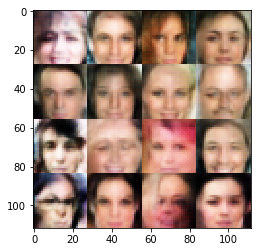

Step 4010, (Epoch 1/1)... Discriminator Loss: 1.2439... Generator Loss: 0.9222
Step 4020, (Epoch 1/1)... Discriminator Loss: 1.3737... Generator Loss: 0.9655
Step 4030, (Epoch 1/1)... Discriminator Loss: 1.4063... Generator Loss: 0.7013
Step 4040, (Epoch 1/1)... Discriminator Loss: 1.5587... Generator Loss: 0.9426
Step 4050, (Epoch 1/1)... Discriminator Loss: 1.5143... Generator Loss: 0.7625
Step 4060, (Epoch 1/1)... Discriminator Loss: 1.4842... Generator Loss: 0.7579
Step 4070, (Epoch 1/1)... Discriminator Loss: 1.3316... Generator Loss: 0.6535
Step 4080, (Epoch 1/1)... Discriminator Loss: 1.5149... Generator Loss: 0.5703
Step 4090, (Epoch 1/1)... Discriminator Loss: 1.3729... Generator Loss: 0.7656
Step 4100, (Epoch 1/1)... Discriminator Loss: 1.4156... Generator Loss: 0.6522


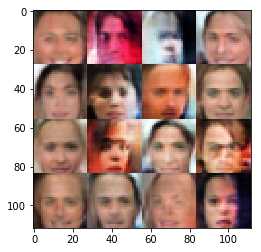

Step 4110, (Epoch 1/1)... Discriminator Loss: 1.3022... Generator Loss: 0.8986
Step 4120, (Epoch 1/1)... Discriminator Loss: 1.1679... Generator Loss: 0.8161
Step 4130, (Epoch 1/1)... Discriminator Loss: 1.3989... Generator Loss: 1.0404
Step 4140, (Epoch 1/1)... Discriminator Loss: 1.4050... Generator Loss: 0.6070
Step 4150, (Epoch 1/1)... Discriminator Loss: 1.2566... Generator Loss: 0.7724
Step 4160, (Epoch 1/1)... Discriminator Loss: 1.4948... Generator Loss: 0.9187
Step 4170, (Epoch 1/1)... Discriminator Loss: 1.2467... Generator Loss: 0.6455
Step 4180, (Epoch 1/1)... Discriminator Loss: 1.5905... Generator Loss: 0.6461
Step 4190, (Epoch 1/1)... Discriminator Loss: 1.3521... Generator Loss: 0.8153
Step 4200, (Epoch 1/1)... Discriminator Loss: 1.4750... Generator Loss: 1.0057


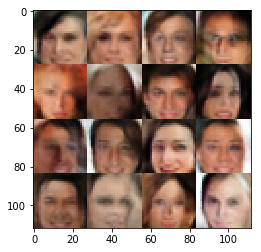

Step 4210, (Epoch 1/1)... Discriminator Loss: 1.4283... Generator Loss: 0.6754
Step 4220, (Epoch 1/1)... Discriminator Loss: 1.4241... Generator Loss: 0.6438
Step 4230, (Epoch 1/1)... Discriminator Loss: 1.4416... Generator Loss: 0.7698
Step 4240, (Epoch 1/1)... Discriminator Loss: 1.2847... Generator Loss: 0.6657
Step 4250, (Epoch 1/1)... Discriminator Loss: 1.3131... Generator Loss: 1.1982
Step 4260, (Epoch 1/1)... Discriminator Loss: 1.3450... Generator Loss: 0.8862
Step 4270, (Epoch 1/1)... Discriminator Loss: 1.3426... Generator Loss: 0.5939
Step 4280, (Epoch 1/1)... Discriminator Loss: 1.4441... Generator Loss: 0.5912
Step 4290, (Epoch 1/1)... Discriminator Loss: 1.2198... Generator Loss: 1.2487
Step 4300, (Epoch 1/1)... Discriminator Loss: 1.3941... Generator Loss: 0.8828


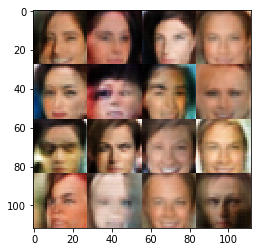

Step 4310, (Epoch 1/1)... Discriminator Loss: 1.4960... Generator Loss: 0.8320
Step 4320, (Epoch 1/1)... Discriminator Loss: 1.3959... Generator Loss: 1.0464
Step 4330, (Epoch 1/1)... Discriminator Loss: 1.3964... Generator Loss: 0.8261
Step 4340, (Epoch 1/1)... Discriminator Loss: 1.2892... Generator Loss: 0.8948
Step 4350, (Epoch 1/1)... Discriminator Loss: 1.3548... Generator Loss: 0.9949
Step 4360, (Epoch 1/1)... Discriminator Loss: 1.4792... Generator Loss: 0.6420
Step 4370, (Epoch 1/1)... Discriminator Loss: 1.3201... Generator Loss: 1.0917
Step 4380, (Epoch 1/1)... Discriminator Loss: 1.3712... Generator Loss: 0.7459
Step 4390, (Epoch 1/1)... Discriminator Loss: 1.3035... Generator Loss: 0.7619
Step 4400, (Epoch 1/1)... Discriminator Loss: 1.4705... Generator Loss: 0.5559


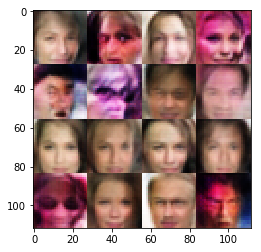

Step 4410, (Epoch 1/1)... Discriminator Loss: 1.4186... Generator Loss: 0.6626
Step 4420, (Epoch 1/1)... Discriminator Loss: 1.1822... Generator Loss: 0.7989
Step 4430, (Epoch 1/1)... Discriminator Loss: 1.3211... Generator Loss: 1.1951
Step 4440, (Epoch 1/1)... Discriminator Loss: 1.4281... Generator Loss: 0.6517
Step 4450, (Epoch 1/1)... Discriminator Loss: 1.2381... Generator Loss: 1.1154
Step 4460, (Epoch 1/1)... Discriminator Loss: 1.4733... Generator Loss: 1.0915
Step 4470, (Epoch 1/1)... Discriminator Loss: 1.5344... Generator Loss: 0.6068
Step 4480, (Epoch 1/1)... Discriminator Loss: 1.3700... Generator Loss: 1.0436
Step 4490, (Epoch 1/1)... Discriminator Loss: 1.3306... Generator Loss: 1.0488
Step 4500, (Epoch 1/1)... Discriminator Loss: 1.3475... Generator Loss: 1.2772


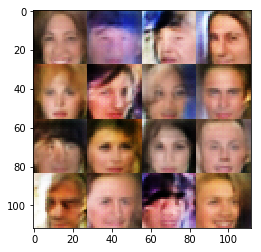

Step 4510, (Epoch 1/1)... Discriminator Loss: 1.2655... Generator Loss: 0.6142
Step 4520, (Epoch 1/1)... Discriminator Loss: 1.2476... Generator Loss: 0.7325
Step 4530, (Epoch 1/1)... Discriminator Loss: 1.2484... Generator Loss: 0.9512
Step 4540, (Epoch 1/1)... Discriminator Loss: 1.2850... Generator Loss: 0.7502
Step 4550, (Epoch 1/1)... Discriminator Loss: 1.3770... Generator Loss: 0.8989
Step 4560, (Epoch 1/1)... Discriminator Loss: 1.1598... Generator Loss: 0.8298
Step 4570, (Epoch 1/1)... Discriminator Loss: 1.4492... Generator Loss: 1.1120
Step 4580, (Epoch 1/1)... Discriminator Loss: 1.1571... Generator Loss: 0.9189
Step 4590, (Epoch 1/1)... Discriminator Loss: 1.3264... Generator Loss: 0.7205
Step 4600, (Epoch 1/1)... Discriminator Loss: 1.3923... Generator Loss: 0.9571


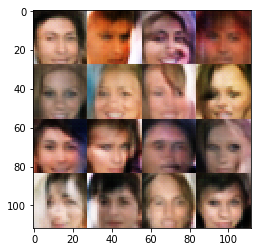

Step 4610, (Epoch 1/1)... Discriminator Loss: 1.5820... Generator Loss: 0.4932
Step 4620, (Epoch 1/1)... Discriminator Loss: 1.4461... Generator Loss: 0.5721
Step 4630, (Epoch 1/1)... Discriminator Loss: 1.3948... Generator Loss: 0.8475
Step 4640, (Epoch 1/1)... Discriminator Loss: 1.4291... Generator Loss: 0.6897
Step 4650, (Epoch 1/1)... Discriminator Loss: 1.2586... Generator Loss: 0.7549
Step 4660, (Epoch 1/1)... Discriminator Loss: 1.3937... Generator Loss: 0.6325
Step 4670, (Epoch 1/1)... Discriminator Loss: 1.3593... Generator Loss: 0.9894
Step 4680, (Epoch 1/1)... Discriminator Loss: 1.2033... Generator Loss: 1.3001
Step 4690, (Epoch 1/1)... Discriminator Loss: 1.4075... Generator Loss: 0.5041
Step 4700, (Epoch 1/1)... Discriminator Loss: 1.4504... Generator Loss: 1.2171


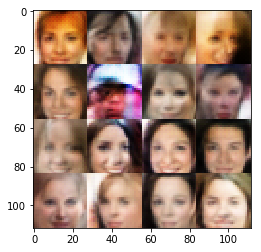

Step 4710, (Epoch 1/1)... Discriminator Loss: 1.2543... Generator Loss: 0.9216
Step 4720, (Epoch 1/1)... Discriminator Loss: 1.3676... Generator Loss: 0.7606
Step 4730, (Epoch 1/1)... Discriminator Loss: 1.3660... Generator Loss: 0.7575
Step 4740, (Epoch 1/1)... Discriminator Loss: 1.4054... Generator Loss: 1.1697
Step 4750, (Epoch 1/1)... Discriminator Loss: 1.3504... Generator Loss: 0.9766
Step 4760, (Epoch 1/1)... Discriminator Loss: 1.4669... Generator Loss: 0.8339
Step 4770, (Epoch 1/1)... Discriminator Loss: 1.2923... Generator Loss: 0.6268
Step 4780, (Epoch 1/1)... Discriminator Loss: 1.4321... Generator Loss: 0.6818
Step 4790, (Epoch 1/1)... Discriminator Loss: 1.4494... Generator Loss: 0.6211
Step 4800, (Epoch 1/1)... Discriminator Loss: 1.2951... Generator Loss: 0.8913


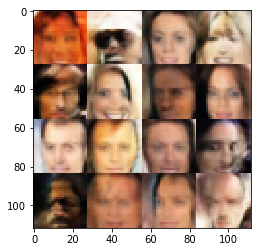

Step 4810, (Epoch 1/1)... Discriminator Loss: 1.4044... Generator Loss: 0.5874
Step 4820, (Epoch 1/1)... Discriminator Loss: 1.3095... Generator Loss: 0.6569
Step 4830, (Epoch 1/1)... Discriminator Loss: 1.2309... Generator Loss: 0.8346
Step 4840, (Epoch 1/1)... Discriminator Loss: 1.5106... Generator Loss: 0.4655
Step 4850, (Epoch 1/1)... Discriminator Loss: 1.1392... Generator Loss: 1.1794
Step 4860, (Epoch 1/1)... Discriminator Loss: 1.0999... Generator Loss: 0.8505
Step 4870, (Epoch 1/1)... Discriminator Loss: 1.3505... Generator Loss: 1.0067
Step 4880, (Epoch 1/1)... Discriminator Loss: 1.4904... Generator Loss: 0.6266
Step 4890, (Epoch 1/1)... Discriminator Loss: 1.3514... Generator Loss: 0.8466
Step 4900, (Epoch 1/1)... Discriminator Loss: 1.1695... Generator Loss: 1.0194


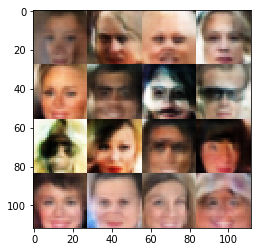

Step 4910, (Epoch 1/1)... Discriminator Loss: 1.6408... Generator Loss: 0.4831
Step 4920, (Epoch 1/1)... Discriminator Loss: 1.2908... Generator Loss: 0.9452
Step 4930, (Epoch 1/1)... Discriminator Loss: 1.6291... Generator Loss: 0.5200
Step 4940, (Epoch 1/1)... Discriminator Loss: 1.3858... Generator Loss: 0.5731
Step 4950, (Epoch 1/1)... Discriminator Loss: 1.3246... Generator Loss: 0.7139
Step 4960, (Epoch 1/1)... Discriminator Loss: 1.2519... Generator Loss: 0.6395
Step 4970, (Epoch 1/1)... Discriminator Loss: 1.3282... Generator Loss: 0.9772
Step 4980, (Epoch 1/1)... Discriminator Loss: 1.2674... Generator Loss: 0.8028
Step 4990, (Epoch 1/1)... Discriminator Loss: 1.3867... Generator Loss: 0.5674
Step 5000, (Epoch 1/1)... Discriminator Loss: 1.2522... Generator Loss: 1.0405


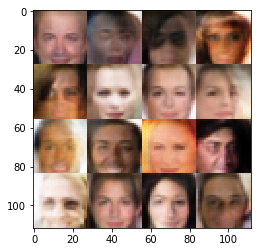

Step 5010, (Epoch 1/1)... Discriminator Loss: 1.2108... Generator Loss: 0.7920
Step 5020, (Epoch 1/1)... Discriminator Loss: 1.3742... Generator Loss: 1.2504
Step 5030, (Epoch 1/1)... Discriminator Loss: 1.3486... Generator Loss: 0.7264
Step 5040, (Epoch 1/1)... Discriminator Loss: 1.1763... Generator Loss: 0.8574
Step 5050, (Epoch 1/1)... Discriminator Loss: 1.4870... Generator Loss: 0.5499
Step 5060, (Epoch 1/1)... Discriminator Loss: 1.5138... Generator Loss: 0.7995
Step 5070, (Epoch 1/1)... Discriminator Loss: 1.3063... Generator Loss: 0.7248
Step 5080, (Epoch 1/1)... Discriminator Loss: 1.3408... Generator Loss: 1.3942
Step 5090, (Epoch 1/1)... Discriminator Loss: 1.3739... Generator Loss: 0.7444
Step 5100, (Epoch 1/1)... Discriminator Loss: 1.1757... Generator Loss: 1.0703


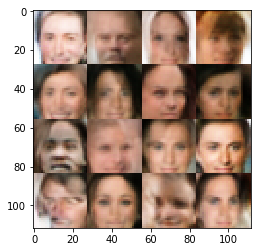

Step 5110, (Epoch 1/1)... Discriminator Loss: 1.1089... Generator Loss: 1.1917
Step 5120, (Epoch 1/1)... Discriminator Loss: 1.3204... Generator Loss: 0.7109
Step 5130, (Epoch 1/1)... Discriminator Loss: 1.4342... Generator Loss: 0.4705
Step 5140, (Epoch 1/1)... Discriminator Loss: 1.1447... Generator Loss: 0.9665
Step 5150, (Epoch 1/1)... Discriminator Loss: 1.2956... Generator Loss: 0.8872
Step 5160, (Epoch 1/1)... Discriminator Loss: 1.4888... Generator Loss: 0.5164
Step 5170, (Epoch 1/1)... Discriminator Loss: 1.4403... Generator Loss: 0.5665
Step 5180, (Epoch 1/1)... Discriminator Loss: 1.4753... Generator Loss: 0.6354
Step 5190, (Epoch 1/1)... Discriminator Loss: 1.3178... Generator Loss: 0.9191
Step 5200, (Epoch 1/1)... Discriminator Loss: 1.3148... Generator Loss: 0.7266


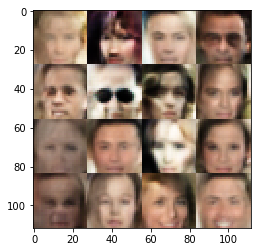

Step 5210, (Epoch 1/1)... Discriminator Loss: 1.2603... Generator Loss: 0.8144
Step 5220, (Epoch 1/1)... Discriminator Loss: 1.1016... Generator Loss: 1.5013
Step 5230, (Epoch 1/1)... Discriminator Loss: 1.2637... Generator Loss: 0.8116
Step 5240, (Epoch 1/1)... Discriminator Loss: 1.3475... Generator Loss: 1.1723
Step 5250, (Epoch 1/1)... Discriminator Loss: 1.3118... Generator Loss: 0.6268
Step 5260, (Epoch 1/1)... Discriminator Loss: 1.4829... Generator Loss: 0.9680
Step 5270, (Epoch 1/1)... Discriminator Loss: 1.2415... Generator Loss: 0.7602
Step 5280, (Epoch 1/1)... Discriminator Loss: 1.1477... Generator Loss: 1.0013
Step 5290, (Epoch 1/1)... Discriminator Loss: 1.4650... Generator Loss: 0.5992
Step 5300, (Epoch 1/1)... Discriminator Loss: 1.2506... Generator Loss: 0.8243


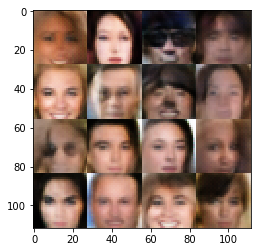

Step 5310, (Epoch 1/1)... Discriminator Loss: 1.1098... Generator Loss: 1.4843
Step 5320, (Epoch 1/1)... Discriminator Loss: 1.3105... Generator Loss: 1.0581
Step 5330, (Epoch 1/1)... Discriminator Loss: 1.2241... Generator Loss: 0.9503
Step 5340, (Epoch 1/1)... Discriminator Loss: 1.4366... Generator Loss: 0.6498
Step 5350, (Epoch 1/1)... Discriminator Loss: 1.2857... Generator Loss: 0.7993
Step 5360, (Epoch 1/1)... Discriminator Loss: 1.6249... Generator Loss: 0.4773
Step 5370, (Epoch 1/1)... Discriminator Loss: 1.2784... Generator Loss: 0.9777
Step 5380, (Epoch 1/1)... Discriminator Loss: 1.2908... Generator Loss: 0.7885
Step 5390, (Epoch 1/1)... Discriminator Loss: 1.2768... Generator Loss: 0.7772
Step 5400, (Epoch 1/1)... Discriminator Loss: 1.3598... Generator Loss: 0.6896


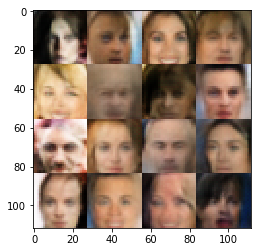

Step 5410, (Epoch 1/1)... Discriminator Loss: 1.1925... Generator Loss: 0.8234
Step 5420, (Epoch 1/1)... Discriminator Loss: 1.4710... Generator Loss: 0.6039
Step 5430, (Epoch 1/1)... Discriminator Loss: 1.1570... Generator Loss: 1.0676
Step 5440, (Epoch 1/1)... Discriminator Loss: 1.3780... Generator Loss: 0.8735
Step 5450, (Epoch 1/1)... Discriminator Loss: 1.1381... Generator Loss: 1.2250
Step 5460, (Epoch 1/1)... Discriminator Loss: 1.3033... Generator Loss: 1.0758
Step 5470, (Epoch 1/1)... Discriminator Loss: 1.2709... Generator Loss: 0.9095
Step 5480, (Epoch 1/1)... Discriminator Loss: 1.3047... Generator Loss: 0.8956
Step 5490, (Epoch 1/1)... Discriminator Loss: 1.4716... Generator Loss: 0.6365
Step 5500, (Epoch 1/1)... Discriminator Loss: 1.1988... Generator Loss: 0.8120


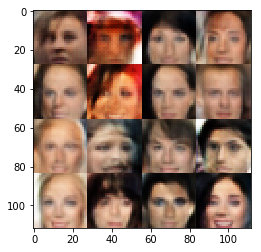

Step 5510, (Epoch 1/1)... Discriminator Loss: 1.4859... Generator Loss: 0.5336
Step 5520, (Epoch 1/1)... Discriminator Loss: 1.1281... Generator Loss: 1.0476
Step 5530, (Epoch 1/1)... Discriminator Loss: 1.2289... Generator Loss: 0.7552
Step 5540, (Epoch 1/1)... Discriminator Loss: 1.5271... Generator Loss: 0.4154
Step 5550, (Epoch 1/1)... Discriminator Loss: 1.4379... Generator Loss: 0.8411
Step 5560, (Epoch 1/1)... Discriminator Loss: 1.1699... Generator Loss: 1.1189
Step 5570, (Epoch 1/1)... Discriminator Loss: 1.3628... Generator Loss: 1.0066
Step 5580, (Epoch 1/1)... Discriminator Loss: 1.6685... Generator Loss: 0.4060
Step 5590, (Epoch 1/1)... Discriminator Loss: 1.2562... Generator Loss: 1.0147
Step 5600, (Epoch 1/1)... Discriminator Loss: 1.3738... Generator Loss: 0.7169


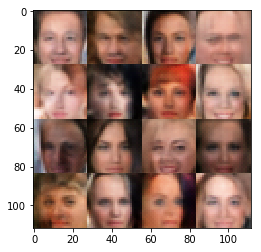

Step 5610, (Epoch 1/1)... Discriminator Loss: 1.2568... Generator Loss: 0.7980
Step 5620, (Epoch 1/1)... Discriminator Loss: 1.5750... Generator Loss: 0.4292
Step 5630, (Epoch 1/1)... Discriminator Loss: 1.2398... Generator Loss: 0.6984
Step 5640, (Epoch 1/1)... Discriminator Loss: 1.2029... Generator Loss: 0.9061
Step 5650, (Epoch 1/1)... Discriminator Loss: 1.2112... Generator Loss: 0.9309
Step 5660, (Epoch 1/1)... Discriminator Loss: 1.2915... Generator Loss: 0.6945
Step 5670, (Epoch 1/1)... Discriminator Loss: 1.3657... Generator Loss: 0.7056
Step 5680, (Epoch 1/1)... Discriminator Loss: 1.4723... Generator Loss: 0.7472
Step 5690, (Epoch 1/1)... Discriminator Loss: 1.2484... Generator Loss: 0.7239
Step 5700, (Epoch 1/1)... Discriminator Loss: 1.0940... Generator Loss: 1.1045


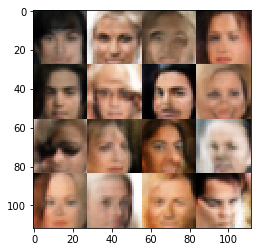

Step 5710, (Epoch 1/1)... Discriminator Loss: 1.3574... Generator Loss: 0.8584
Step 5720, (Epoch 1/1)... Discriminator Loss: 1.1705... Generator Loss: 1.1082
Step 5730, (Epoch 1/1)... Discriminator Loss: 1.1404... Generator Loss: 1.0680
Step 5740, (Epoch 1/1)... Discriminator Loss: 1.2524... Generator Loss: 0.7858
Step 5750, (Epoch 1/1)... Discriminator Loss: 1.3043... Generator Loss: 0.8394
Step 5760, (Epoch 1/1)... Discriminator Loss: 1.1530... Generator Loss: 1.0336
Step 5770, (Epoch 1/1)... Discriminator Loss: 1.2791... Generator Loss: 0.8755
Step 5780, (Epoch 1/1)... Discriminator Loss: 1.1304... Generator Loss: 0.8325
Step 5790, (Epoch 1/1)... Discriminator Loss: 1.3217... Generator Loss: 0.7064
Step 5800, (Epoch 1/1)... Discriminator Loss: 1.4591... Generator Loss: 0.5529


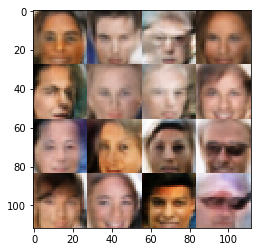

Step 5810, (Epoch 1/1)... Discriminator Loss: 1.2931... Generator Loss: 0.6971
Step 5820, (Epoch 1/1)... Discriminator Loss: 1.2214... Generator Loss: 0.6526
Step 5830, (Epoch 1/1)... Discriminator Loss: 1.2200... Generator Loss: 1.4442
Step 5840, (Epoch 1/1)... Discriminator Loss: 1.2284... Generator Loss: 1.0646
Step 5850, (Epoch 1/1)... Discriminator Loss: 1.2270... Generator Loss: 1.0326
Step 5860, (Epoch 1/1)... Discriminator Loss: 1.2412... Generator Loss: 0.8336
Step 5870, (Epoch 1/1)... Discriminator Loss: 1.6624... Generator Loss: 0.3525
Step 5880, (Epoch 1/1)... Discriminator Loss: 1.1722... Generator Loss: 0.9831
Step 5890, (Epoch 1/1)... Discriminator Loss: 1.0321... Generator Loss: 1.0195
Step 5900, (Epoch 1/1)... Discriminator Loss: 1.2747... Generator Loss: 0.9262


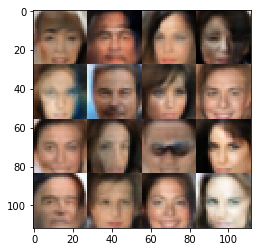

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.